In [1]:
import pandas as pd

df=pd.read_csv('common-products-from-all-stores.csv')

In [3]:
df.shape

(5908, 8)

In [4]:
import re

extract all possible units for measurment of the quantity

In [5]:
# Extract all words that might be units
def extract_potential_units(text_series):
    units = set()
    for text in text_series:
        if pd.notna(text):
            # Find patterns like "number + word"
            matches = re.findall(r'\d+\.?\d*\s*([a-zA-Z]+)', str(text).lower())
            units.update(matches)
    return units

all_units = extract_potential_units(df['name'])
print(all_units)



{'pop', 'fresh', 'tea', 'portions', 'savoury', 'to', 'kg', 'fruit', 'up', 'classic', 'year', 'water', 'mini', 'caramel', 'packs', 'bags', 'x', 'seed', 'mugs', 'optipro', 'toddler', 'cl', 'gms', 'ltr', 'sauce', 'sachets', 'cheese', 'slices', 'litre', 'grain', 'vanilla', 'litter', 'masman', 'cups', 'lahori', 'box', 'ultimate', 'lt', 'ml', 'happy', 'whitening', 'kgx', 'growing', 'month', 'supreme', 'off', 'batata', 'degrees', 'steamed', 'bottle', 'n', 'tin', 'pack', 'grams', 'in', 'mixed', 'k', 'black', 'instant', 'milk', 'oz', 'rs', 'round', 'promo', 'e', 'coffee', 'sachet', 'months', 'g', 'yellow', 'liter', 'gm', 'follow', 'the', 'tom', 'mami', 'singles', 'sp', 'envelope', 'crunchy', 'fruits', 's', 'l', 'soft', 'mlx', 'p', 'selling', 'taco', 'bag', 'slice', 'infant', 'followup', 'm', 'gmx', 'snack', 'pcs', 'pc', 'grm', 'plus'}


from seen above wrote all the units and their standardization

In [7]:
# Manually curated list of common units
unit_standardization = {
    # Weight
    "kg": "kg", "kgx": "kg", "k": "kg",
    "g": "g", "gm": "g", "gms": "g", "grm": "g", "gmx": "g",
    "oz": "oz",
    
    # Volume
    "l": "L", "ltr": "L", "lt": "L", "liter": "L", 
    "litre": "L", "litre": "L", "litter": "L",
    "ml": "ml", "mlx": "ml","m": "ml",  # Ambiguous - could be meter
    "cl": "cl",
    
    # Count
    "pcs": "pieces", "pc": "pieces", "p": "pieces",
    "pack": "pack", "packs": "pack",
    "portions": "portions",
    "slices": "slices",
    
    # Container
    #"box": "box",'MEIJI KIDS PLUS VANILLA 4 BOX 600GM'
    
    # Unclear
    #"x": "units", "n": "units", "s": "units"
}


In [ ]:
#for checking different units with index
def extract_potential_units(text_series,index_series):
    units = set()
    for text, index in zip(text_series, index_series):
        if pd.notna(text):
            # Find patterns like "number + word"
            matches = re.findall(r'\d+\.?\d*\s*p\b', str(text).lower())
            matches = set(matches)
            matches=[match +"-----"+str(index) for match in matches ]
            units.update(matches)
    return units

all_units = extract_potential_units(df['name'],df.index)
print(all_units)


ml
{'12p-----2138', '25p-----4852', '600p-----5468', '24p-----2166', '12p-----2133'}


In [ ]:
#f.loc[2138]['name']


'PEAK FREANS CAKE UP DB CHOCOLATE RS.20 PROMO 19.5 GM BOX 12P'

creating a pattern with all those units present in the column

In [8]:
# Create regex pattern - IMPORTANT: longer units first to avoid partial matches!
units_list = sorted(unit_standardization.keys(), key=len, reverse=True)
units_pattern = '|'.join(re.escape(unit) for unit in units_list)



# Complete pattern: number + optional space + unit
pattern = rf'\d+\.?\d*\s*({units_pattern})\b'

print("Pattern:", pattern)
print("\n")

Pattern: \d+\.?\d*\s*(portions|litter|slices|liter|litre|packs|pack|kgx|gms|grm|gmx|ltr|mlx|pcs|kg|gm|oz|lt|ml|cl|pc|k|g|l|m|p)\b




standardizing the column

In [9]:
def extract_and_standardize_unit(text):
    """Extract unit from text and standardize it"""
    if pd.isna(text):
        return None
    
    match = re.search(pattern, str(text).lower(), re.IGNORECASE)
    if match:
        original_unit = match.group(1).lower()
        return unit_standardization.get(original_unit, original_unit)
    return None

def extract_quantity(text):
    """Extract numeric quantity from text"""
    if pd.isna(text):
        return None
    
    match = re.search(pattern, str(text).lower(), re.IGNORECASE)
    if match:
        # Extract the number part
        number_match = re.search(r'\d+\.?\d*', match.group(0))
        return float(number_match.group(0)) if number_match else None
    return None

def remove_unit_pattern(text):
    """Remove quantity + unit pattern from text and clean up"""
    if pd.isna(text):
        return text
    
    # Remove the pattern
    cleaned = re.sub(pattern, '', str(text).lower(), flags=re.IGNORECASE)
    
    # Clean up extra spaces and strip
    cleaned = re.sub(r'[\s()]+', ' ', cleaned).strip()
    
    return cleaned

# Apply to your dataframe
df['standardized_unit'] = df['name'].apply(extract_and_standardize_unit)
df['quantity'] = df['name'].apply(extract_quantity)
df["cleaned_name"] = df["name"].apply(remove_unit_pattern)

# Display the results
display(df[['name', 'quantity', 'standardized_unit', 'cleaned_name']].sample(20))

,name,quantity,standardized_unit,cleaned_name
2022,BALOCCO WAFERS CACAO 250 GM,250.0,g,balocco wafers cacao
4546,Youngs Natural Honey 250g,250.0,g,youngs natural honey
3858,ITALIA FRUIT COCKTAIL TIN 836 GM,836.0,g,italia fruit cocktail tin
2409,EL SABOR SAUCE GUACAMOLE DIP 300 GM,300.0,g,el sabor sauce guacamole dip
2487,YOUNGS RANCH SAUCE SALAD DRESSING 275 GM,275.0,g,youngs ranch sauce salad dressing
1036,KISAN ATTA JOOH 500 GM,500.0,g,kisan atta jooh
4026,NATURES OWN POMACE OLIVE OIL CHOLESTROL FREE 4...,4.0,L,natures own pomace olive oil cholestrol free
1525,DORITOS CHIPS SPICY SWEET CHILI 311.8 GM,311.8,g,doritos chips spicy sweet chili
3097,PRIMADE FITNESS SPORTS DRINK LYCHEE BLISS 600 ML,600.0,ml,primade fitness sports drink lychee bliss
2371,SHANGRILA PERI PERI GARLIC SAUCE 285 ML,285.0,ml,shangrila peri peri garlic sauce


while extracting some products of al-fateh had no quantity because it was inside and i then hardcode them to proper quantities

In [10]:


indexes=df[(df["store"]=="al-fateh") & (df["category"]=="dry_fruits_&_dates---fateh") & (df["standardized_unit"].isna())].index.tolist()

print(indexes)

# Manually set standardized unit and quantity for these specific cases

#why it is not working

# Get column position first
col_unit = df.columns.get_loc("standardized_unit")
col_qty = df.columns.get_loc("quantity")

print(col_unit, col_qty)

for idx in indexes:
    df.iloc[idx, col_unit] = "kg"
    df.iloc[idx, col_qty] = 1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 145]
8 9


making a single column for product-links

In [11]:
df["product-link"]=df["product-link"].str.strip().fillna('')+ df["product_link"].str.strip().fillna('')

In [12]:
df.drop(columns=["product_link"], inplace=True)

renaming the column name

In [13]:
df.rename(columns={"common_category": "cleaned_category"}, inplace=True)

In [14]:
display(df.sample(10))

,store,category,name,price,cleaned_category,product-link,image_url,standardized_unit,quantity,cleaned_name
2429,al-fateh,sauces_&_soups---fateh,HEINZ CHILI SAUCE 300G,Rs.463Rs.545,Condiments,https://alfatah.pk/products/heinz-chili-sauce-...,NaN,g,300.0,heinz chili sauce
4051,al-fateh,drinking_water---fateh,NESTLE WATER PURE LIFE 1.5 LTR-CARTON,Rs.540,Beverages,https://alfatah.pk/products/nestle-water-pure-...,NaN,L,1.5,nestle water pure life -carton
5552,Metro,butter---metro,Nurpur Butter 100GM,Rs. 415,Dairy,https://www.metro-online.pk/detail/dairy/butte...,https://www.metro-online.pk/_next/image?url=%2...,g,100.0,nurpur butter
1190,al-fateh,rice_products---fateh,FALAK BROWN BASMATI RICE 1.5KG PCS,Rs.675,Staples,https://alfatah.pk/products/falak-brown-basmat...,NaN,kg,1.5,falak brown basmati rice pcs
1024,al-fateh,ghee---fateh,CANOLIVE BANASPATI GHEE 2.5 KG,"Rs.1,350",Cooking Oils,https://alfatah.pk/products/canolive-banaspati...,NaN,kg,2.5,canolive banaspati ghee
1811,al-fateh,biscuits---fateh,LOACKER WAFER NAPOLITANER 175 GM,Rs.745,Snacks,https://alfatah.pk/products/loacker-wafer-napo...,NaN,g,175.0,loacker wafer napolitaner
5438,Metro,canned_fruits---metro,Delmonte Pineapple Tidbits 567 GM,"Rs. 1,019",Canned Foods,https://www.metro-online.pk/detail/grocery/can...,https://www.metro-online.pk/_next/image?url=%2...,g,567.0,delmonte pineapple tidbits
4945,Jalal Sons,"yoghurt,_butter,_cream_and_cheese---jalalsons",Happy Cow Slice Gouda 150Gm,"Rs 1,044",Dairy,https://jalalsons.com.pk/product/happy-cow-sli...,NaN,g,150.0,happy cow slice gouda
1942,al-fateh,biscuits---fateh,KRUNCHEES SUGAR FREE BROWNIES VANILLA 100 GM,Rs.595,Snacks,https://alfatah.pk/products/krunchees-sugar-fr...,NaN,g,100.0,krunchees sugar free brownies vanilla
3631,al-fateh,cheese---fateh,FF MOZARELLA CHEESE 2 KG,"Rs.4,645",Dairy,https://alfatah.pk/products/ff-mozarella-chees...,NaN,kg,2.0,ff mozarella cheese


dropping null quantities rows

In [17]:
print(df.shape)
df.dropna(subset=["standardized_unit"], inplace=True)
print(df.shape)

(5713, 10)
(5713, 10)


In [20]:
print(df["standardized_unit"].isna().sum())
print(df["quantity"].isna().sum())

0
0


In [22]:
print(df["standardized_unit"].value_counts())

standardized_unit
g           3614
ml          1034
L            567
kg           425
pieces        54
slices         6
oz             5
portions       4
cl             2
pack           2
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np

class UnitStandardizer:
    """
    Standardizes various units to base units for machine learning
    """
    
    def __init__(self):
        # Define conversion factors to base units
        self.weight_conversions = {
            'kg': 1000,      # to grams
            'g': 1,
            'mg': 0.001,
            'oz': 28.3495,   # ounces to grams
            'lb': 453.592,   # pounds to grams
        }
        
        self.volume_conversions = {
            'L': 1000,       # to ml
            'l': 1000,       # to ml
            'ml': 1,
            'cl': 10,        # centiliters to ml
            'dl': 100,       # deciliters to ml
            'fl oz': 29.5735 # fluid ounces to ml
        }
        
        # Units that are countable/discrete
        self.count_units = ['pieces', 'slices', 'portions', 'pack', 'items']
        
    def standardize_unit(self, quantity, unit):
        """
        Convert quantity and unit to standardized form
        Returns: (standardized_quantity, standardized_unit, unit_category)
        """
        if pd.isna(unit) or pd.isna(quantity):
            return None, None, None
            
        unit_lower = str(unit).lower().strip()
        
        # Weight conversions (to grams)
        if unit_lower in self.weight_conversions:
            std_quantity = float(quantity) * self.weight_conversions[unit_lower]
            return std_quantity, 'g' #, 'weight'
        
        # Volume conversions (to ml)
        elif unit_lower in self.volume_conversions:
            std_quantity = float(quantity) * self.volume_conversions[unit_lower]
            return std_quantity, 'ml' #, 'volume'
        
        # Count units (keep as is)
        elif unit_lower in self.count_units:
            return float(quantity), 'pieces' #, 'count'
        
        # Unknown unit
        else:
            return float(quantity), unit_lower #, 'other'
    
    def process_dataframe(self, df, quantity_col='quantity', unit_col='standardized_unit'):
        """
        Process a dataframe with quantity and unit columns
        Returns: DataFrame with standardized columns
        """
        df = df.copy()
        
        # Apply standardization
        standardized = df.apply(
            lambda row: self.standardize_unit(row[quantity_col], row[unit_col]), 
            axis=1
        )
        
        # Unpack results
        df['cleaned_quantity'] = standardized.apply(lambda x: x[0])
        df['cleaned_unit'] = standardized.apply(lambda x: x[1])
        #df['unit_category'] = standardized.apply(lambda x: x[2])
        
        return df
    
    def create_ml_features(self, df, quantity_col='cleaned_quantity', unit_col='cleaned_unit'):
        """
        Create features suitable for ML model training
        Returns: DataFrame with ML-ready features
        """
        df_processed = df.copy()
        
        # Create one-hot encoding for unit categories
        df_encoded = pd.get_dummies(df_processed, columns=['cleaned_unit',"store","cleaned_category"], prefix=['quantity','store',"categpory"])
        
        # Optional: Create log-transformed quantity (useful for many ML models)
        df_encoded['log_quantity'] = np.log1p(df_encoded['cleaned_quantity'])
        
        return df_encoded

# Initialize standardizer
standardizer = UnitStandardizer()

# Process data
df_standardized = standardizer.process_dataframe(df)
df_standardized=  standardizer.create_ml_features(df_standardized)


#df_standardized.columns

df_standardized.drop(columns=['category', 'name', 'product-link', 'image_url','standardized_unit', 'quantity', 'cleaned_name', 'cleaned_quantity'], inplace=True)

#print("Standardized Data:")
#print(df_standardized)
#print("\n" + "="*60 + "\n")

# Create ML features
#df_ml_ready = standardizer.create_ml_features(df)
##print("ML-Ready Features:")
#print(df_ml_ready)
#print("\n" + "="*60 + "\n")

# Show summary statistics by category
#print("Summary by Unit Category:")
#print(df_standardized.groupby('unit_category')['standardized_quantity'].describe())

In [46]:
display(df_standardized.sample(10))

,price,quantity_g,quantity_ml,quantity_pieces,store_Imtiaz,store_Jalal Sons,store_Metro,store_al-fateh,categpory_Baby Food,categpory_Beverages,categpory_Breakfast Foods,categpory_Canned Foods,categpory_Condiments,categpory_Cooking Oils,categpory_Dairy,categpory_Dry Fruits & Nuts,categpory_Snacks,categpory_Spices & Seasonings,categpory_Staples,log_quantity
1101,Rs.375,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,4.836282
3188,Rs.450,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,5.771441
54,"Rs.3,995",True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,6.685861
5423,Rs. 149,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,4.174387
4362,Rs 548,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,4.110874
5812,Rs. 85.00,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,6.216606
4066,Rs.255,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,7.313887
2128,Rs.240,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,3.020425
4580,Rs 464,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,6.908755
1039,"Rs.1,400",True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,9.210440


In [ ]:
df_standardized.to_csv('pre_processed_data_2.csv', index=False)


In [17]:
df_standardized.columns

Index(['price', 'quantity_g', 'quantity_ml', 'quantity_pieces', 'store_Imtiaz',
       'store_Jalal Sons', 'store_Metro', 'store_al-fateh',
       'categpory_Baby Food', 'categpory_Beverages',
       'categpory_Breakfast Foods', 'categpory_Canned Foods',
       'categpory_Condiments', 'categpory_Cooking Oils', 'categpory_Dairy',
       'categpory_Dry Fruits & Nuts', 'categpory_Snacks',
       'categpory_Spices & Seasonings', 'categpory_Staples', 'log_quantity'],
      dtype='object')

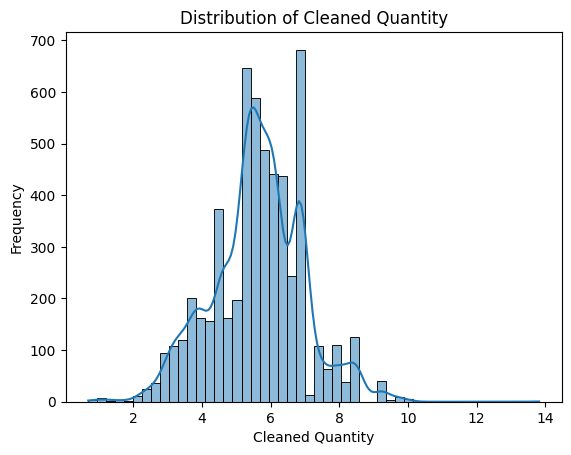

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


#histogram of cleaned_quantity
sns.histplot(df_standardized['log_quantity'], bins=50, kde=True)
plt.title('Distribution of Cleaned Quantity')
plt.xlabel('Cleaned Quantity')
plt.ylabel('Frequency')
plt.show()

In [19]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5713 entries, 0 to 5712
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          5713 non-null   object 
 1   quantity_g                     5713 non-null   bool   
 2   quantity_ml                    5713 non-null   bool   
 3   quantity_pieces                5713 non-null   bool   
 4   store_Imtiaz                   5713 non-null   bool   
 5   store_Jalal Sons               5713 non-null   bool   
 6   store_Metro                    5713 non-null   bool   
 7   store_al-fateh                 5713 non-null   bool   
 8   categpory_Baby Food            5713 non-null   bool   
 9   categpory_Beverages            5713 non-null   bool   
 10  categpory_Breakfast Foods      5713 non-null   bool   
 11  categpory_Canned Foods         5713 non-null   bool   
 12  categpory_Condiments           5713 non-null   b

now we gonna clean price column

In [22]:
df_standardized["price"].isna().sum()

np.int64(0)

first we extracting and understanding th pattern

In [49]:
import re
import numpy as np
def find_pattern(p):
    pattern=r"\D+"
    temp=re.findall(pattern,p)
    return temp

arr=[]
#destrcutre array int ot 
arr=df_standardized["price"].apply(find_pattern)
arr=[item for sublist in arr for item in sublist]
arr=np.array(arr)
print(arr)

print(np.unique(arr))

['Rs.' ' - Rs.' ',' ... '.' 'Rs. ' '.']
[' - Rs.' ',' '.' 'Rs ' 'Rs.' 'Rs. ']


now we cleaning the pattern

In [50]:
import re
import numpy as np
def ectrcact_price(p):
    pattern=r"Rs\.?\s*"
    temp=re.sub(pattern,"",p)
    return temp

arr=df_standardized["price"].apply(ectrcact_price)
print(arr)
arr=[re.match(r"[0-9]+,?.?[0-9]+",str(a)).group(0) for a in arr]
print(arr)

0         720 - 2,880
1       1,020 - 4,080
2       1,020 - 4,080
3       1,300 - 5,200
4         620 - 2,480
            ...      
5708           425.00
5709           525.00
5710           525.00
5711           589.00
5712           425.00
Name: price, Length: 5713, dtype: object
['720', '1,020', '1,020', '1,300', '620', '720', '1,450', '1,450', '1,170', '390', '1,375', '545', '620', '1,220', '495', '620', '295', '3,750', '2,400', '1,490', '1,400', '445', '245', '595', '290', '585', '345', '295', '140', '365', '180', '295', '240', '150', '150', '150', '220', '220', '980', '180', '285', '240', '150', '1,195', '2,295', '210', '315', '130', '2,495', '195', '210', '195', '400', '2,195', '3,995', '475', '210', '195', '3,595', '595', '210', '285', '180', '125', '945', '1,045', '210', '195', '160', '195', '240', '115', '1,595', '295', '300', '1,220', '200', '425', '210', '235', '210', '240', '225', '170', '235', '260', '245', '425', '210', '425', '445', '195', '480', '425', '170', '240', '1

In [51]:
print(len(arr))
print(df_standardized.shape)

5713
(5713, 20)


In [127]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Step 1: Extract first words (often brands)
first_word = (
    checking['cleaned_name'].str.split().str[0].str.lower().fillna('') + " " + 
    checking['cleaned_name'].str.split().str[1].str.lower().fillna('')
).str.strip()

# Step 2: Use TF-IDF to find important terms
vectorizer = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 2),  # Single words and 2-word combinations
    min_df=2,  # Must appear at least twice
    stop_words='english'
)

# Fit on product names
tfidf_matrix = vectorizer.fit_transform(first_word)

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Calculate importance scores
importance = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
word_importance = pd.DataFrame({
    'word': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("Potential brand names (high importance words):")
print(word_importance)

Potential brand names (high importance words):
               word  importance
69           nestle   75.502463
42            juice   65.305296
91            tapal   51.287696
17           coffee   41.306367
63          nescafe   37.242385
..              ...         ...
98           yellow    6.046726
40           joiner    5.910966
41     joiner juice    5.910966
68         nesfruta    5.905121
72  nestle nesfruta    5.905121

[100 rows x 2 columns]
